In [53]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import scipy as sp

import delfi.distribution as dd

from tqdm import tqdm_notebook as tqdm

%run ../pdf_mog.py

dtype = torch.FloatTensor

from parameters import ParameterSet

import matplotlib.pyplot as plt

In [54]:
class MoG(nn.Module):
    def __init__(self, n_components, dim, a=None, ms=None, Ss=None, dtype=dtype, seed=None):
        """ Trainable MoG using torch.autograd 
        
        Parameters
        ---------
        n_components : int
            Number of components in the mixture
        dim : int
            Dimension of the distribution
        dtype : torch.dtype
            dtype for the variables
        """
        super().__init__()

        self.n_components = n_components
        self.dim = dim
        self.dtype = dtype
        
        self.softmax = nn.Softmax(dim=0)
        
        if a is not None:
            a = np.array(a)
            assert(a.shape == (n_components,))
            self.weights = Variable(torch.log(torch.Tensor(a)).type(self.dtype), requires_grad=False)
        else:
            self.weights = nn.Parameter(torch.ones(n_components).type(self.dtype))
            
        if ms is not None:
            ms = np.array(ms)
            assert(ms.shape == (n_components, dim))
            self.mus = Variable(torch.Tensor(ms).type(self.dtype), requires_grad=False)
        else:
            self.mus = nn.Parameter(torch.Tensor(n_components, dim).normal_().type(self.dtype))
            
        if Ss is not None:
            Ss = np.array(Ss)
            assert(Ss.shape == (n_components, dim, dim))
            Ls = np.linalg.cholesky(Ss)
            ids = np.diag_indices(dim)
            Ls.T[ids] = np.log(Ls.T[ids])           # Logarithm of diagonals
            ids = np.tril_indices(dim)
            self.Lvecs = Variable(torch.Tensor(Ls.T[ids].T.reshape(-1)).type(self.dtype), requires_grad=False)
        else:
            self.Lvecs = nn.Parameter(
                torch.Tensor(n_components*(dim**2+dim) // 2).uniform_(0, 0.1).type(self.dtype))
    
    def eval(self, data):
        """Evaluate MoG at data points
        
        Parameters
        ---------
        data : array of size n x dim
            Data points at which the MoG is to be evaluated
        
        Returns
        ---------
        lprobs : array of size n
            Log probabilities of data points
        """
            
        if type(data) == np.ndarray:
            data = torch.from_numpy(data)
        data = Variable(data.type(self.dtype), requires_grad=False)
        
        # weights
        weights = self.softmax(self.weights)
                
        Ls = self.get_Ls()

        lprobs = multivariate_mog_pdf(data, weights, self.mus, Ls, log=True)
        
        return lprobs, (weights, self.mus, Ls)
        
    def get_Ls(self):
        """Compute Cholesky factors of the covariance matrices
        
        Returns
        -------
        Ls : array (n_components x n_dim x n_dim)
            Cholesky factors of the components
        """
        
        # covariance factors
        Ls = Variable(torch.zeros(self.n_components, self.dim, self.dim)).type(self.dtype)
        
        # assign vector to lower triangle of Ls
        (idx1, idx2) = np.tril_indices(self.dim)
        Ls[:, idx1, idx2] = self.Lvecs

        # apply exponential to get positive diagonal
        (idx1, idx2) = np.diag_indices(self.dim)
        Ls[:, idx1, idx2] = torch.exp(Ls[:, idx1, idx2])
        
        return Ls
        
    def forward(self, inp):
        """Evaluate the mean log probabilities of the data points 
        
        Parameters
        ----------
        inp : array (n x dim)
            Data points at which the MoG is to be evaluated
            
        Returns
        -------
        lprobs : dtype
            Mean log probability of the data points
        (weights, mus, Ls) : torch.Variable
            Parameters of the MoG
        """
        
        lprobs, (weights, mus, Ls) = self.eval(inp)
        return -torch.mean(lprobs), (weights, mus, Ls)
    
    def get_distribution(self):
        """Convert MoG to delfi.distribution.GaussianMixture
        
        Returns
        -------
        dist : delfi.distribution.GaussianMixture
            Converted MoG
        """
        
        a = np.copy(self.softmax(self.weights).data.numpy())
        ms = np.copy(self.mus.data.numpy())
        Ls = self.get_Ls().data.numpy()
        
        Us = np.linalg.inv(Ls)
        
        return dd.MoG(a=a, ms=ms, Us=Us)

    def set_distribution(self, target):
        if isinstance(target, dd.Gaussian):
            target = dd.MoG(a=[1], ms=[target.m], Ss=[target.S])
            
        if not isinstance(target, dd.MoG):
            raise TypeError("Cannot initialise trainable MoG to non-MoG target distribution")
            
        assert self.dim == target.ndim, "Cannot initialise trainable MoG to target distribution of wrong dimension"
            
        if target.ncomp != self.n_components:
            raise TypeError("Cannot initialise trainable MoG to MoG target distribution with different number of components")
        
        self.weights.data = dtype(np.log(target.a))
        self.mus.data = dtype([ np.copy(x.m) for x in target.xs ])
        
        Ls = np.copy([ np.linalg.cholesky(x.S) for x in target.xs ])
        (idx1, idx2) = np.diag_indices(self.dim)
        Ls[:,idx1,idx2] = np.log(Ls[:,idx1,idx2])
        
        # assign vector to lower triangle of Ls
        (idx1, idx2) = np.tril_indices(self.dim)
        self.Lvecs.data = dtype(Ls[:, idx1, idx2])
     

In [55]:
class MoGTrainer:
    def __init__(self, mog, samples, weights, minibatch=10, dtype=dtype, optim=torch.optim.SGD, seed=None, **optim_kwargs):
        self.mog = mog
        self.trn_data = [ samples, weights ]
        self.dtype = dtype
        
        assert len(samples) == len(weights)
        
        self.optim = optim
        self.optim_kwargs = optim_kwargs
        
        self.minibatch = minibatch
        
        if self.minibatch == -1:
            self.minibatch = len(samples)
        
        if seed is not None:
            self.rng = np.random.RandomState(seed=seed)
        else:
            self.rng = np.random.RandomState()

        
    def get_loss(self, batch):
        """ Compute the loss function
        
        Returns
        -------
        loss : torch.Variable
            Loss of the MoG
        """
        
        samples = batch[0]
        weights = batch[1]
        
        llsamples, _ = self.mog.eval(samples)
        
        loss = -torch.sum(llsamples * Variable(torch.Tensor(weights), requires_grad=False))
        return loss
        
    def train(self, nsteps=1):
        optim = self.optim(self.mog.parameters(), **self.optim_kwargs)
        
        batches = list(self.iterate_minibatches())
        
        losses = np.empty((nsteps, len(batches)))
        batch_losses = np.empty((nsteps, len(batches)))
        mogs = [ [] for step in range(nsteps)]
        
        for step in tqdm(range(nsteps)):
            for i,batch in enumerate(batches):
                optim.zero_grad()
                batch_loss = self.get_loss(batch)
                old_batch_loss = np.asscalar(batch_loss.data.numpy())

                batch_loss.backward()
                last_data = (self.mog.weights.clone(), self.mog.mus.clone(), self.mog.Lvecs.clone())
                optim.step()
                
                batch_loss = self.get_loss(batch)
                batch_losses[step,i] = np.asscalar(old_batch_loss - batch_loss.data.numpy())
                
                mogs[step].append(self.mog.get_distribution())
                
                total_loss = self.get_loss(self.trn_data)
                
                losses[step,i] = np.asscalar(total_loss.data.numpy())

        return { "losses" : losses, "batch_losses" : batch_losses, "batches" : batches, "mogs" : mogs }
    
    def iterate_minibatches(self):
        n_samples = len(self.trn_data[0])                                                                                                                                       
        indices = np.arange(n_samples)
            
        self.rng.shuffle(indices)                                                                                                                                               
                
        start_idx = 0
                                                                                                                                                                           
        for start_idx in range(0, n_samples-self.minibatch+1, self.minibatch):
            excerpt = indices[start_idx:start_idx + self.minibatch]                                                                                                             
                
            yield [ self.trn_data[k][excerpt] for k in range(len(self.trn_data)) ]                                                                                                    
               
        rem_i = n_samples - (n_samples % self.minibatch)                                                                                                                        
        if rem_i != n_samples:                                                                                                                                             
            excerpt = indices[rem_i:]
            yield [ self.trn_data[k][excerpt] for k in range(len(self.trn_data)) ]


In [56]:
params = ParameterSet({})

params.seed = 42

params.n_comps = 1
params.dim = 2

params.prop_width = 0.1

params.a = np.ones(params.n_comps) / params.n_comps
params.ms = [ np.zeros(params.dim) for i in range(params.n_comps) ]
params.Ss = [ np.eye(params.dim) for i in range(params.n_comps) ]
params.prop_Ss = [ (params.prop_width ** 2) * np.eye(params.dim) for i in range(params.n_comps) ]


In [119]:
offset = np.array([[1.5, -0.5]])

params.n_samples = 1000
minibatch = 10

lr = 1
nsteps = 10

In [135]:
gt = dd.MoG(a=params.a, ms=params.ms, Ss=params.Ss, seed=seed)
prop = dd.MoG(a=params.a, ms=params.ms, Ss=params.prop_Ss, seed=seed)

start_dist = dd.MoG(a=params.a, ms=params.ms + offset, Ss=params.Ss, seed=seed)

samples = prop.gen(params.n_samples)
weights = gt.eval(samples, log=False) / prop.eval(samples, log=False)

weights /= np.sum(weights)

sample_mean = np.mean(samples * weights[...,np.newaxis], axis=0)
bestimate = dd.MoG(a=params.a, ms=[sample_mean], Ss=params.Ss, seed=seed)

start_dist = bestimate
mog = MoG(params.n_comps, params.dim, a=params.a, Ss=params.Ss, seed=seed)

mog.set_distribution(start_dist)

trainer = MoGTrainer(mog, samples, weights, minibatch=minibatch, lr=lr / params.n_samples, 
                     optim=torch.optim.Adam)

data = trainer.train(nsteps=nsteps)

batches = data['batches']
mogs = data['mogs']

ms = np.asarray([[ mog.xs[0].m for mog in mogl ] for mogl in mogs ]).reshape(-1, 2)

A Jupyter Widget

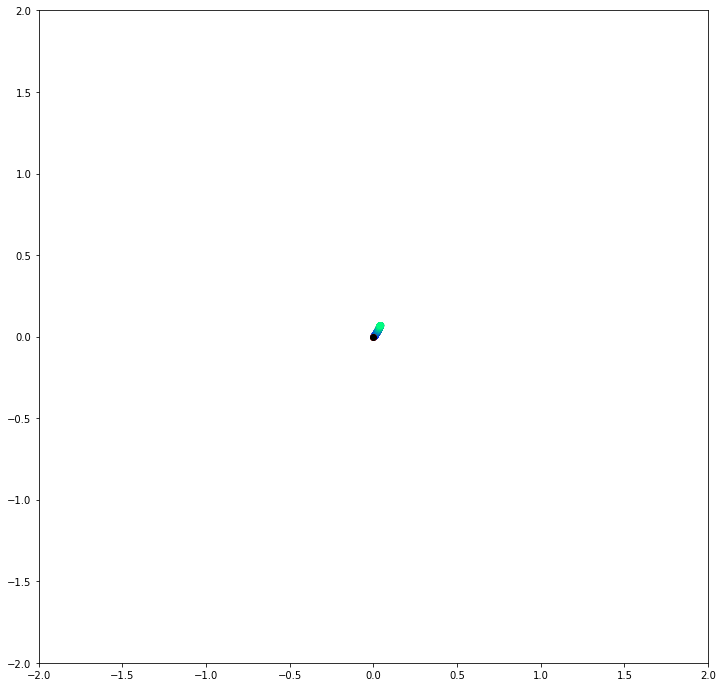

In [136]:
plt.figure(figsize=(12,12))

cmap=plt.get_cmap("winter")

ax = plt.gca()
ax.set_ylim([-2, 2])
ax.set_xlim([-2, 2])

plt.scatter(ms.T[0], ms.T[1], c=np.linspace(0,1,len(ms.T[0])), cmap=cmap, alpha=0.3)
plt.scatter(*gt.xs[0].m, c="gray")

plt.scatter(*bestimate.xs[0].m, c="r")
plt.scatter(*start_dist.xs[0].m, c="k")

plt.show();

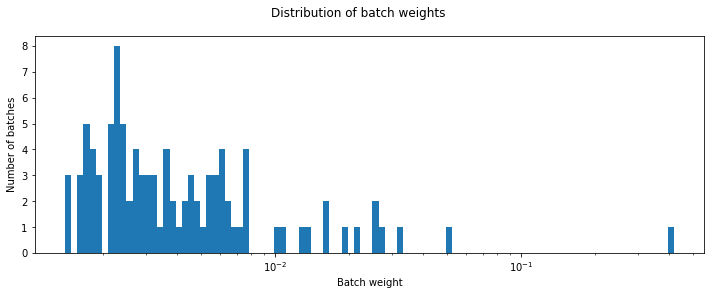

In [137]:
batch_iws = np.array([ np.sum(b[1]) for b in batches ])

plt.figure(figsize=(12,4))

logbins = np.geomspace(np.min(batch_iws), np.max(batch_iws), 100)
plt.hist(batch_iws, bins=logbins)

plt.suptitle("Distribution of batch weights")
ax = plt.gca()
ax.set_xscale('log')

ax.set_xlabel("Batch weight")
ax.set_ylabel("Number of batches")

plt.show()

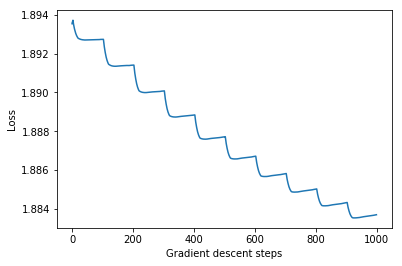

In [138]:
plt.figure()

losses_linear = []
for l in data['losses']:
    losses_linear.extend(l)
    
plt.plot(losses_linear)

ax = plt.gca()

ax.set_ylabel("Loss")
ax.set_xlabel("Gradient descent steps")

plt.show();

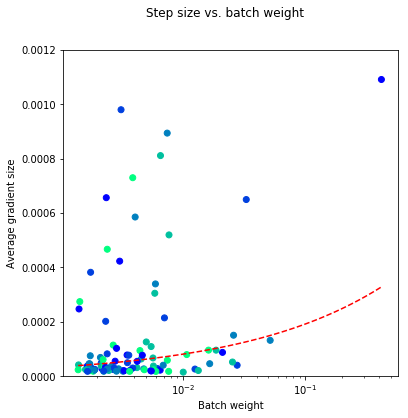

Log-log correlation: 0.29746572769986784


In [154]:
batch_dists = np.empty((len(batches),nsteps))
mogs_linear = [start_dist]
for mog in mogs:
    mogs_linear.extend(mog)
    
for step in range(nsteps):
    for i, batch in enumerate(batches):
        diff = mogs_linear[step * len(batches) + i + 1].xs[0].m - mogs_linear[step * len(batches) + i].xs[0].m
        batch_dists[i,step] = np.sqrt(np.sum(diff ** 2))
        
batch_dist_means = np.mean(batch_dists, axis=1)
batch_dist_stds = np.sqrt(np.mean((batch_dists - np.mean(batch_dists)) ** 2, axis=1))

plt.figure(figsize=(6,6))

plt.suptitle("Step size vs. batch weight")

lreg_sl, lreg_yi, _, _, _ = sp.stats.linregress(np.log(batch_iws), np.log(batch_dist_means))

cidx = np.tile(np.linspace(0,1,5), len(batch_iws) // 5)

imax = np.argmax(batch_iws)

cidx = np.roll(cidx, imax)
plt.scatter(batch_iws, batch_dist_means,  c=cidx, cmap=cmap)

# Plot regression curve
xlist = np.geomspace(np.min(batch_iws), np.max(batch_iws), 100)
ylist = np.exp(lreg_yi + lreg_sl * np.log(xlist))
plt.plot(xlist, ylist, c='r', ls='--')

ax = plt.gca()
ax.set_xscale("log")

ax.set_xlabel("Batch weight")
ax.set_ylabel("Average gradient size")
        
ax.set_ylim([0, 1.1 * np.max(batch_dist_means)])
plt.show();

print("Log-log correlation: {}".format(np.corrcoef(np.log(batch_iws), np.log(batch_dist_means))[0,1]))